<a href="https://colab.research.google.com/github/LeoMcBills/ML_imageGeneration/blob/main/ML_ImageGen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variation autoencoders

GANs

In [22]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Reshape, Conv2DTranspose, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, )
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Data Preparation

In [2]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

In [3]:
dataset = tf.data.Dataset.from_tensor_slices(mnist_digits)

In [4]:
len(dataset)

70000

In [5]:
BATCH_SIZE = 128
LATENT_DIM = 2

In [6]:
train_dataset = (
    dataset
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [7]:
train_dataset

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

# Modeling

#Sampling

In [8]:
class Sampling(Layer):

  def call(self, inputs):
    mean, log_var = inputs

    return mean + tf.math.exp(0.5*log_var)*tf.random.normal(shape = (BATCH_SIZE, LATENT_DIM))

# Encoder

In [9]:
encoder_inputs = Input(shape=(28, 28, 1))

x = Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
x = Conv2D(32, 3, activation='relu', strides=2, padding='same')(x)

x = Flatten()(x)
x = Dense(16, activation='relu')(x)

mean = Dense(LATENT_DIM,)(x)
log_var = Dense(LATENT_DIM, )(x)

z = Sampling()([mean, log_var])

encoder_model = Model(encoder_inputs, [z, mean, log_var], name='encoder')
encoder_model.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 32)           320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 7, 7, 32)             9248      ['conv2d[0][0]']              
                                                                                                  
 flatten (Flatten)           (None, 1568)                 0         ['conv2d_1[0][0]']            
                                                                                            

#Decoder

In [10]:
latent_inputs = Input(shape=(LATENT_DIM,))

x = Dense(7*7*64, activation='relu')(latent_inputs)
x = Reshape((7,7,64))(x)

x = Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)

decoder_output = Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)
decoder_model = Model(latent_inputs, decoder_output, name='decoder')
decoder_model.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        36928     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 32)        18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 28, 28, 1)         289 

#Overall VAE Model

In [11]:
vae_input = Input(shape=(28,28,1), name="vae_input")
x = encoder_model(vae_input)
output = decoder_model(x)
vae = Model(vae_input, output, name="vae")
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 vae_input (InputLayer)      [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 encoder (Functional)        [(128, 2),                   34740     ['vae_input[0][0]']           
                              (None, 2),                                                          
                              (None, 2)]                                                          
                                                                                                  
 decoder (Functional)        (None, 28, 28, 1)            65089     ['encoder[0][0]',             
                                                                     'encoder[0][1]',           

#Training

In [12]:
OPTIMIZER = Adam(learning_rate = 1e-3)
EPOCHS = 30

In [13]:
def custom_loss(y_true, y_pred, mean, log_var):

  loss_rec = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(y_true, y_pred), axis=(1, 2)))
  loss_reg = tf.reduce_mean(tf.reduce_sum(-0.5*(log_var+1-tf.math.square(mean)-tf.math.exp(log_var)), axis = 1))
  return loss_rec+loss_reg

In [14]:
def training_block(x_batch):
  with tf.GradientTape() as recorder:
    z, mean, log_var = encoder_model(x_batch)
    y_pred = decoder_model(z)
    y_true = x_batch
    loss = custom_loss(y_true, y_pred, mean, log_var)

  partial_derivatives = recorder.gradient(loss, vae.trainable_weights)
  OPTIMIZER.apply_gradients(zip(partial_derivatives, vae.trainable_weights))
  return loss

In [15]:
def neuralearn(epochs):
  for epoch in range(1, epochs+1):
    print('Training starts for epoch number {}'.format(epoch))

    for step, x_batch in enumerate(train_dataset):
      loss = training_block(x_batch)
    print('Training Loss is: ', loss)
  print('Training Complete!!!')

In [17]:
# neuralearn(EPOCHS)

#Testing

In [18]:
scale=1
n=16

In [20]:
grid_x = np.linspace(-scale, scale, 16)
grid_y = np.linspace(-scale, scale, 16)

In [21]:
print(grid_x)
print(grid_y)

[-1.         -0.86666667 -0.73333333 -0.6        -0.46666667 -0.33333333
 -0.2        -0.06666667  0.06666667  0.2         0.33333333  0.46666667
  0.6         0.73333333  0.86666667  1.        ]
[-1.         -0.86666667 -0.73333333 -0.6        -0.46666667 -0.33333333
 -0.2        -0.06666667  0.06666667  0.2         0.33333333  0.46666667
  0.6         0.73333333  0.86666667  1.        ]


1/1 [==============================] - 0s 27ms/step


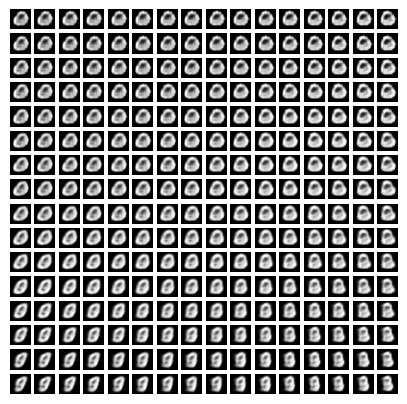

In [26]:
plt.figure(figsize=(5, 5))
k=0
for i in grid_x:
  for j in grid_y:
    ax=plt.subplot(n, n, k+1)

    input=tf.constant([[i,j]])
    out=vae.layers[2].predict(input)[0][...,0]
    plt.imshow(out, cmap="Greys_r")
    plt.axis('off')
    k+=1